In [17]:
using Distributions, LinearAlgebra, Plots
import Random
Random.seed!(1234)

function rowenhorst(mean, uncond_sd, rho, num_states)
    """
    Rowenhort's method to approximate AR(1) process with Markov chain (ln y_t = mu + rho y_{t-1} + e_t)
    Note: this function also normalizes effective labour to one.
    
    #### Fields
    
    - 'mean': unconditional mean of income process
    - 'uncond_sd': unconditional standard deviation
    - 'rho': autocorrelation coefficient
    - 'num_states': number of states we want discretized
    
    #### Returns
    
    - 'transition_matrix': num_states x num_states array where
    transition_matrx[i,j] is prob. of going from i to j
    - 'ygrid': vector of income state space of length num_states
    
    """
    
    # construct grids
    step_r = uncond_sd*sqrt(num_states-1)
    ygrid = -1:2/(num_states-1):1
    ygrid = mean .+ step_r*ygrid
    
    # initialize transition probabilities 
    p = (rho+1)/2
    q = p
    
    transition_matrix = [p 1-p; 1-q q]
    
    # rowenhort's method
    for i = 2:num_states-1
        a1 = [transition_matrix zeros(i, 1); zeros(1, i+1)] 
        a2 = [zeros(i,1) transition_matrix; zeros(1, i+1)]
        a3 = [zeros(1, i+1); transition_matrix zeros(i,1)]
        a4 = [zeros(1, i+1); zeros(i,1) transition_matrix]
        
        transition_matrix = p*a1 + (1-p)*a2 + (1-q)*a3 + q*a4
        transition_matrix[2:i, :] = transition_matrix[2:i, :]/2
    end
    
    for i = 1:num_states
       transition_matrix[i,:] = transition_matrix[i,:]/sum(transition_matrix[i,:])
    end
    
    # get stationary distribution to normalize effective labour to L=1
    pi = eigvecs(transition_matrix')[:,num_states]
    
    # normalize pi
    pi = pi./sum(pi)
    
    # exponentiate
    ygrid = exp.(ygrid)
    
    # normalize effective labour
    ygrid = ygrid/sum(pi.*ygrid)
    
    return transition_matrix, ygrid
end

function setgrids(bc, apoints, amax, num_states, ygrid)
    Amat = [i for i in range(bc, length = apoints, stop= amax), j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end

setgrids (generic function with 1 method)

In [20]:
using Parameters, Plots, LinearAlgebra, Interpolations, BenchmarkTools
apoints = 500
amax = 200  # asset max
beta = 0.98 # discount factor
alpha = 0.11 # capital share
deprec = 0.025 # depreciation rate
gamma = 1 # elasticity of substitution
bc = 0 # borrowing constraint (must be weakly negative)
rho = 0.966  # autocorr of income process
num_states = 7; # number of states for income process
sd = 0.13;
mean = 0 # mean of income process
uncond_sd = 0.13/sqrt(1-rho^2) # unconditional sd
transition_matrix = rowenhorst(mean, uncond_sd, rho, num_states)[1] # transition matrix
ygrid = rowenhorst(mean, uncond_sd, rho, num_states)[2] # grid for income process
Amat = setgrids(bc, apoints, amax, num_states, ygrid)[1] # asset grid
Ymat = setgrids(bc, apoints, amax, num_states, ygrid)[2]; # income grid
up(c,gamma) = c.^(-gamma)
invup(x,gamma) = x.^(-1/gamma)

function getc(gamma,beta,transition_matrix; rnext,cnext)
    upnext = beta.*(1+rnext).*up(cnext,gamma)*transition_matrix' # future marginal utility
    c = invup(upnext,gamma) # current consumption
    return c
end

geta(Amat,Ymat; r,w,c) =  1/(1+r).*(c.+Amat.-w.*Ymat)

geta (generic function with 1 method)

0.010.88164609752145670.8900000000000001(500, 7)
policy function iteration successful!


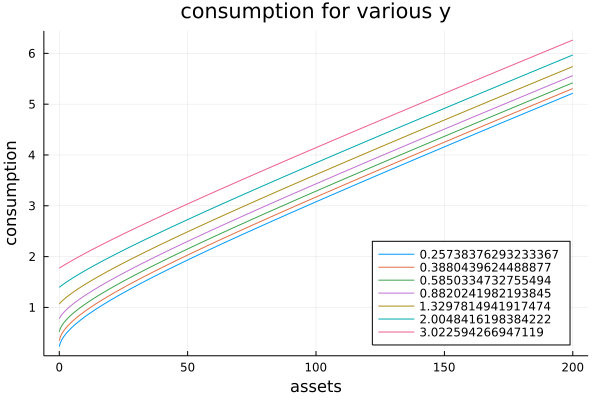

In [21]:
r = 0.01
tol=1e-8
maxiter=1000
Z = ((r + deprec)/alpha)^alpha # normalize aggregate income so that Y=1
w = (1-alpha)*Z*(alpha*Z/(r+deprec))^(alpha/(1-alpha)) # wage rate given guess for r
cnext = @. r*Amat+Ymat*w # initial guess for policy function iteration 
cbinding = @. (1+r)*Amat + w*Ymat - bc # get consumption when borrowing constraint binds
rnext = r
cpolicy = similar(Amat)

println(r, Z, w, size(Amat))

for i=1:maxiter
    c = getc(gamma, beta, transition_matrix; rnext=rnext, cnext=cnext)
    a = geta(Amat, Ymat; r=r, w=w, c=c)
    cnonbinding = similar(Amat)

    for i = 1:num_states
        cnonbinding[:,i] = LinearInterpolation(a[:,i], c[:,i], extrapolation_bc = Line()).(Amat[:,i])
    end
    
    for j = 1:num_states
       c[:,j] = (Amat[:,j] .> a[1,j]) .*cnonbinding[:,j] .+ (Amat[:,j] .<= a[1,j]).*cbinding[:,j]
    end

    anext = @. (1+r)*Amat + w*Ymat - c

    if norm(c-cnext,Inf)<tol 
        println("policy function iteration successful!")
        cpolicy = copy(c)
        break
    else
        cnext = c
    end
end

plot(Amat[:,1], cpolicy, label = ygrid', xlabel = "assets", ylabel = "consumption", title = "consumption for various y", legend = :bottomright)